# BIA4 Breast Cancer Cell Segmentation & Tumor Type Classification

## Outline
- Introduction 
- Install and Dependencies 
- Import Packages
- Unsupervised Cell Nucleus Instance Segmentation
- Cell Property Calculation 
- Tumor Diagnosis with Dense Convolutional Neural Network
- Graphical User Interface
- References 

## Introduction 

Breast cancer is the most common cancer type in women, inducing huge burden to global healthcare systems (Łukasiewicz et 
al., 2021). Early tumor detection greatly improves patient outcomes, however, has proven difficult in developing countries due to lack of access to quality care partly because current diagnosis procedure heavily relies on expert’s opinion (Unger-Saldaña, 2014; Wang, 2017). 

Cell properties such as cell population density, nuclear-cytoplasmic ratio, nuclear size, and nuclear shape are the fundamental basis for biopsy to distinguish malignant and benign breast tumors (Makki, 2015). For example, malignant tumors are more likely to exhibit enhanced cell population density, slightly increased nuclear-cytoplasmic ratio, and irregular nuclear shape, whereas benign tumors tend to exhibit a monotonic, homogeneous, round cell population (Makki, 2015). 

Deep learning, especially convolutional neural networks (CNN), has shown superior performance in several computer vision 
tasks and is being widely applied in biomedical imaging. Therefore, in this project we aim to develop software to automate breast cancer diagnosis and cellular property calculation based on histology.

&nbsp;

This software was designed to do **breast cancer cell segmentation** and **tumor type classification**. 

Based on the segmentation results, cell properties such as *cell population density*, *nuclear-cytoplasmic ratio*, *nuclear size* and *nuclear shape irregularity* were measured, providing more information to clinical experts to aid with microscopic biopsy diagnosis. 

## Install and Dependencies 

**Download the package from this GitHub repository.** The data used to build this classifier are included in the `data` directory. 


Note that we use Python 3.10 for software development.
We recommend using the latest version of the following packages although older versions would also be compatible.

The source code of all implemented functions in this documentation can be found in ./utils.py for your information.

||||| Packages |||||
|:--------:|:-------:|:-------:|:--------:|:-------:|:-------:|:--------:|:-------:|:-------:|
|matplotlib|  monai  |numpy|pandas|PySimpleGUI|scipy|skimage|sklearn|torch|

## Import Packages

In [1]:
import os
from scipy import ndimage as ndi
import scipy.spatial
import scipy.signal
import torch
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io as im
from skimage.measure import regionprops, regionprops_table
from skimage.morphology import remove_small_objects
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.filters import gaussian
import sklearn.cluster
import monai
from monai.data import DataLoader, ImageDataset
from monai.transforms import (
    EnsureChannelFirst,
    Compose,
    ScaleIntensity,
    ResizeWithPadOrCrop
)
import PySimpleGUI as sg
from utils import *

## Unsupervised Cell Nucleus Instance Segmentation
### Read Example Data
Note: the input biopsy image should be in the size of 700 x 460 pixels

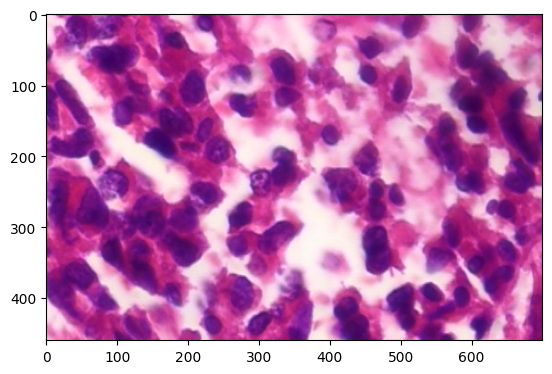

In [2]:
img = im.imread("../data/train/malignant/SOB_M_DC-14-2773-400-007.png")
plt.imshow(img)
plt.show()

### KMeans & Watershed

Using semantic segmentation KMeans, the image is separated into three distinct parts: cytoplasm, nuclei, and extracellular component.

Using instance segmentation Watershed Algorithm, individual nuclei are isolated based on the identified nuclei part. After filtering out small noisy instances, cell nuclei are displayed.

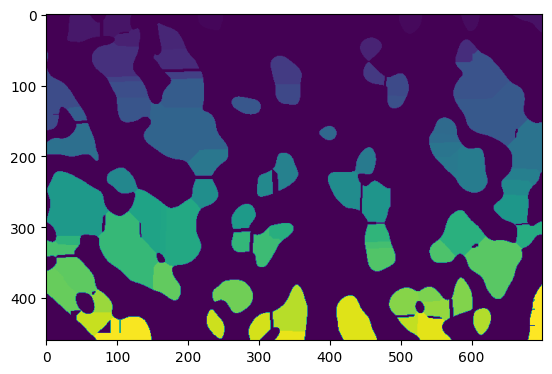

In [3]:
# do KMeans and Watershed segmentation, the results also include some cell properties 
res, cell_population_density, nuclear_cytoplasmic_ratio = kmeans_watershed_nuclei_seg(img, sigma=7)
plt.imshow(res)
plt.show()

### Cell Population Intensity & Nuclear-Cytoplasmic Ratio 

Based on the area of KMeans clusters, cell population density and nuclear-cytoplasmic ratio are calculated. 

We mathematically formulated the cell population density $D$ and nuclear-cytoplasmic ratio $R$ as follows:

$D = \frac{S(nuclei)}{S(total)}$

$R = \frac{S(nuclei)}{S(cytoplasm)}$

where we can easily calculate the area $S$ by counting the number of pixels contained within each part. 

By these two definitions, larger $D$ indicates more intensive cell population distribution in the microscopic image and larger $I$ represents cells with bigger nuclei and less cytoplasm, which is a critical characteristic for malignant breast tumor cells. 

In [4]:
print(f'Mean cell population density: {round(cell_population_density, 2)}')
print(f'Nuclear VS cytoplasmic ratio: {round(nuclear_cytoplasmic_ratio, 2)}')

Mean cell population density: 23.94
Nuclear VS cytoplasmic ratio: 117.24


## Cell Property Calculation

### Cell Number & Nuclear Size 

Since breast cancer cells usually have only one nucleus, cell number is counted based on the number of identified instances after applying Watershed segmentation. 

Nuclear size is also calculated based on the results of Watershed segmentation, which equals the area of each instance. 

In [5]:
# calculate cell number and nuclear size based on the results of Watershed segmentation 
cell_num, nuclear_mean_size, nuclear_mean_intensity, data = cell_property(img, res)
print(f'Cell Number: {cell_num}')
print(f'Mean Nuclear Size: {round(nuclear_mean_size, 2)}')
print(f'Mean Nuclear Image Intensity: {round(nuclear_mean_intensity, 2)}')
print()
print("Details for each cell.")
print(data)

Cell Number: 86
Mean Nuclear Size: 1416.34
Mean Nuclear Image Intensity: 94.31

Details for each cell.
    label    area  area_bbox  axis_row  axis_col  mean_intensity
0       2   683.0      828.0        23        36       98.985359
1       3   721.0      924.0        28        33       98.400832
2       4   470.0      624.0        24        26       89.563121
3       6   497.0     1092.0        26        42      113.621060
4       7  1083.0     1320.0        33        40      106.876885
..    ...     ...        ...       ...       ...             ...
81    115  2473.0     3591.0        63        57       80.245990
82    116  1259.0     1872.0        39        48       89.913423
83    117   480.0      559.0        13        43       92.029167
84    120  1881.0     2673.0        33        81      100.192096
85    121  1046.0     1560.0        78        20       90.057361

[86 rows x 6 columns]


### Nuclear Shape Irregularity

The irregularity of nuclear shape is another essential indicator of malignant breast cancer. As before, nuclear shape irregularity is calculated based on the results of Watershed segmentation. 

Specifically, we used a 3-by-3 kernal, which calculates the average of neighboring pixels, to detect border pixels, because they will have pixels of different classes in their neighborhood.

We mathematically formulated the shape irregularity $I$ of a nucleus as follows:

$I = \frac{max(d) - min(d)}{max(d)}$

where $d$ is the vector of distances of the all border pixels to the weight center of a nucleus.

By this definition, a perfectly round nucleus would have $I=0$ and $I$ would increase as the shape deviates from being circular.

Mean nuclear shape irregularity: 0.14
Std nuclear shape irregularity: 0.05

Show cell edges: 


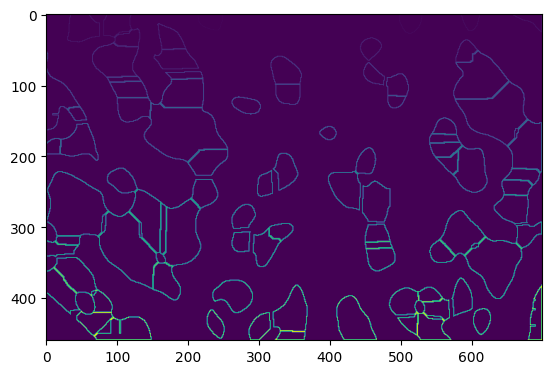

In [6]:
# calculate nuclear shape irregularity based on the results of Watershed segmentation 
plot_df, nuclear_shape_mean_irregularity, nuclear_shape_std_irregularity = border_cell_from_ins_map(res)
print(f'Mean nuclear shape irregularity: {round(nuclear_shape_mean_irregularity, 2)}')
print(f'Std nuclear shape irregularity: {round(nuclear_shape_std_irregularity, 2)}')
print()
print('Show cell edges: ')
plt.imshow(plot_df)
plt.show()

## Tumor Diagnosis with Dense Convolutional Neural Network
### Model Training Pipeline
We used a DenseNet121 architecture pre-implemented
in the MONAI package (based on PyTorch) for breast tumor type classification.

#### Load Data & Labels
We first loaded all data and labels following the original train-test split ratio provided on the Kaggle website.

In [7]:
train_img, train_labels = load_data_labels(root_path="../data/train")
test_img, test_labels = load_data_labels(root_path="../data/test")

#### Set-up GPU/CPU for training

In [8]:
pinmemory = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Construct Datasets
As a standard step of PyTorch training, we constructed image datasets and loaders. Batch size of 4 was selected
after experimenting the trade-off between training stability and GPU memory load.

In [9]:
train_ds, train_loader = construct_datasets(images=train_img,
                                            labels=train_labels,
                                            batch_size=4,
                                            pinmemory=pinmemory)
test_ds, test_loader = construct_datasets(images=test_img,
                                          labels=test_labels,
                                          batch_size=4,
                                          pinmemory=pinmemory)

#### Initialize Model & Optimizer
We used the DenseNet121 pre-implemented in the MONAI package as model backbone. Adam optimizer for gradient decent was used.

In [10]:
model = monai.networks.nets.DenseNet121(spatial_dims=2, in_channels=3, out_channels=2).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)

#### Training
In preliminary testing, we found that the model converges at ~100 epoches, for demonstration purposes the following code only
used a single epoch. We also implemented a timer module to estimate remaining time required for training.

In [11]:
model_train(max_epochs=1,
            model=model,
            optimizer=optimizer,
            train_loader=train_loader,
            train_ds=train_ds,
            writer=SummaryWriter(),
            device=device,
            loss_function=loss_function,
            val_interval=1,
            save_name="../models/best_metric_model_classification_DenseNet121.pth",
            test_loader=test_loader)

----------
epoch 1/1
50/287, train_loss: 0.3703
Estimated Time Left: 0:06:02.297484
100/287, train_loss: 0.4176
Estimated Time Left: 0:01:25.176745
150/287, train_loss: 0.7430
Estimated Time Left: 0:01:03.290354
200/287, train_loss: 0.1827
Estimated Time Left: 0:00:40.323475
250/287, train_loss: 0.4384
Estimated Time Left: 0:00:17.337421
epoch 1 average loss: 0.4944
saved new best metric model
Current epoch: 1 current accuracy: 0.8312 
Best accuracy: 0.8312 at epoch 1
Training completed, best_metric: 0.8312 at epoch: 1


### Inference & Evaluation

#### Single Inference Example
To predict the tumor type for each image we need both the image path and the pretrained model path.

In [12]:
prediction = model_inference(img_pth=test_img[0],
                             model_pth="../models/best_metric_model_classification_Dense121_9560.pth").cpu()
print(f'The prediction for {test_img[0]} is: {"malignant" if np.array(prediction)[0] else "benign"}')

The prediction for ../data/test\benign\SOB_B_A-14-22549AB-400-001.png is: benign


#### Model Evaluation
To demonstrate the performance of our model we calculated the accuracy on the test dataset.

In [13]:
# construct a new dataset of batch size 1 for inference
test_ds, test_loader = construct_datasets(images=test_img,
                                          labels=test_labels,
                                          batch_size=1,
                                          pinmemory=pinmemory)

# load pretrained model
model = load_trained_model(model_pth="../models/best_metric_model_classification_Dense121_9560.pth",
                           model_class=monai.networks.nets.DenseNet121,
                           device=device)
model.eval()

# test model accuracy on the whole dataset
wrong_images = []
wrong_labels = []
model.eval()
num_correct = 0.0
metric_count = 0
for val_data in test_loader:
    val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
    with torch.no_grad():
        val_outputs = model(val_images)
        value = torch.eq(val_outputs.argmax(dim=-1), val_labels)
        metric_count += len(value)
        num_correct += value.sum().item()
        if value.sum().item() != val_images.shape[0]:
            wrong_images.append(val_images)
            wrong_labels.append(val_labels)
metric = num_correct / metric_count
print(f'The model prediction accuracy on test dataset is: {round(metric*100, 2)}%')

The model prediction accuracy on test dataset is: 95.6%


### Model Training History
Model training history can be visualized using Tensorboard by running the following script:

``` bash
tensorboard --logdir .\runs\DenseNet121_history
```

## Graphical User Interface



To facilitate the usability of our software, we have adopted a graphical user interface. 

By specifying the image input and result output paths and parameters related to image analysis, users can obtain results such as tumor cell properties and classified tumor types from a new window, which provides information for clinical diagnosis and thus reduces the labor burden of experts in observing biopsies. 

### To initialize the GUI of our software, please run the following script

```bash
python3 ./scripts/main.py
```

## References 

Łukasiewicz, S., Czeczelewski, M., Forma, A., Baj, J., Sitarz, R., & Stanisławek, A. (2021). Breast Cancer-Epidemiology, Risk Factors, Classification, Prognostic Markers, and Current Treatment Strategies-An Updated Review. Cancers, 13(17), 4287. https://doi.org/10.3390/cancers13174287

Makki J. (2015). Diversity of Breast Carcinoma: Histological Subtypes and Clinical Relevance. Clinical medicine insights. Pathology, 8, 23–31. https://doi.org/10.4137/CPath.S31563

Spanhol, F. A., Oliveira, L. S., Petitjean, C., & Heutte, L. (2016). A Dataset for Breast Cancer Histopathological Image Classification. IEEE transactions on bio-medical engineering, 63(7), 1455–1462. https://doi.org/10.1109/TBME.2015.2496264

Unger-Saldaña K. (2014). Challenges to the early diagnosis and treatment of breast cancer in developing countries. World journal of clinical oncology, 5(3), 465–477. https://doi.org/10.5306/wjco.v5.i3.465

Wang L. (2017). Early Diagnosis of Breast Cancer. Sensors (Basel, Switzerland), 17(7), 1572. https://doi.org/10.3390/s17071572